In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px

In [3]:
folder = '/Users/erikagutierrez/Documents/BSE/Term_3/Masters_Thesis/MT_predicting_BSD/processing/storage_final/'

stations = pd.read_csv(folder + 'stations_data.csv')
trips = pd.read_csv(folder + 'trips_data.csv')
stations['time'] = pd.to_datetime(stations['time'])

### NEED TO ADD THIS CODE TO SCRIPT THAT MAKES GIANT DF

#trips['station_unlock'] = trips['station_unlock'].astype(float)

trips['unlock_date'] = pd.to_datetime(trips['unlock_date'], format='ISO8601')
trips['year'] = trips['unlock_date'].apply(lambda x: x.year)
trips['month'] = trips['unlock_date'].apply(lambda x: x.month)
trips['day'] = trips['unlock_date'].apply(lambda x: x.day)

/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_17631/2713649208.py:3: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  stations = pd.read_csv(folder + 'stations_data.csv')
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_17631/2713649208.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv(folder + 'trips_data.csv')


### Stations Dataset Summary

In [4]:
stations.rename({'Unnamed: 0': 'Index'}, axis = 1, inplace = True)
print(stations.columns)
stations.head(3)

Index(['Index', 'activate', 'name', 'reservations_count', 'light',
       'total_bases', 'free_bases', 'number', 'longitude', 'no_available',
       'address', 'latitude', 'dock_bikes', 'id_station', 'time', 'day',
       'month', 'year', 'hour'],
      dtype='object')


,Index,activate,name,reservations_count,light,total_bases,free_bases,number,longitude,no_available,address,latitude,dock_bikes,id_station,time,day,month,year,hour
0,0,1.0,Puerta del Sol A,0.0,2.0,30.0,16.0,1a,-3.701834,0.0,Puerta del Sol nº 1,40.417214,13.0,1.0,2022-02-01,1,2,2022,0.0
1,1,1.0,Puerta del Sol B,0.0,2.0,30.0,11.0,1b,-3.701603,0.0,Puerta del Sol nº 1,40.417313,14.0,2.0,2022-02-01,1,2,2022,0.0
2,2,1.0,Miguel Moya,0.0,1.0,24.0,2.0,2,-3.705842,0.0,Calle Miguel Moya nº 1,40.420589,19.0,3.0,2022-02-01,1,2,2022,0.0


In [5]:
print(stations.dtypes)

Index                          int64
activate                     float64
name                          object
reservations_count           float64
light                        float64
total_bases                  float64
free_bases                   float64
number                        object
longitude                     object
no_available                 float64
address                       object
latitude                      object
dock_bikes                   float64
id_station                   float64
time                  datetime64[ns]
day                            int64
month                          int64
year                           int64
hour                         float64
dtype: object


In [6]:
print(stations.isna().sum())
# 55198 nulls for reservations_count, free_bases, and dock_bikes. Do these occur at the same time?

Index                     0
activate                  0
name                      0
reservations_count    55198
light                     0
total_bases               0
free_bases            55198
number                    0
longitude                 0
no_available              0
address                   0
latitude                  0
dock_bikes            55198
id_station                0
time                      0
day                       0
month                     0
year                      0
hour                      0
dtype: int64


In [7]:
# value counts 
print(stations.light.value_counts())
print(stations.activate.value_counts())
print(stations.no_available.value_counts())
print(stations.reservations_count.value_counts())

light
2.0    2963792
0.0    2513692
1.0    1214350
3.0     340436
Name: count, dtype: int64
activate
1.0    7032270
Name: count, dtype: int64
no_available
0.0    6691834
1.0     340436
Name: count, dtype: int64
reservations_count
0.0    6580026
1.0     350017
2.0      41128
3.0       5809
4.0         89
6.0          3
Name: count, dtype: int64


### Trips Dataset Summary

In [8]:
trips.rename({'Unnamed: 0': 'Index'}, axis = 1, inplace = True)
print(trips.columns)
trips.head(5)

Index(['Index', 'dock_lock', 'dock_unlock', 'trip_minutes', 'station_unlock',
       'station_lock', 'unlock_date', 'year', 'month', 'day'],
      dtype='object')


,Index,dock_lock,dock_unlock,trip_minutes,station_unlock,station_lock,unlock_date,year,month,day
0,0,14.0,11.0,2.783333,219,59.0,2019-11-01 00:00:00+00:00,2019,11,1
1,1,5.0,7.0,2.916667,135,182.0,2019-11-01 00:00:00+00:00,2019,11,1
2,2,15.0,3.0,6.133333,189,87.0,2019-11-01 00:00:00+00:00,2019,11,1
3,3,17.0,1.0,6.566667,189,87.0,2019-11-01 00:00:00+00:00,2019,11,1
4,4,13.0,24.0,6.083333,55,49.0,2019-11-01 00:00:00+00:00,2019,11,1


In [9]:
print(trips.dtypes)

Index               int64
dock_lock         float64
dock_unlock       float64
trip_minutes      float64
station_unlock     object
station_lock      float64
unlock_date        object
year                int64
month               int64
day                 int64
dtype: object


### Nulls Analysis

In [10]:
def nulls_temporal_distribution(df, granularity, nulls_col):
    
    nulls_df = df[df[f'{nulls_col}'].isna()].groupby(granularity)['Index'].count().reset_index()
    
    granularity_dict = {}
    
    for i in range(len(granularity)):
        granularity_dict.update({granularity[i]:nulls_df[granularity[i]]})
    if len(granularity) < 3:
        granularity_dict.update({'day':pd.Series([1 for x in range(len(nulls_df))])})
    
    nulls_df['time_granularity'] = pd.to_datetime(granularity_dict)
    
    fig = px.line(nulls_df, x="time_granularity", y="Index", title=f'{nulls_col} null counts')
    fig.show()

#### Stations Nulls Analysis

Current takeaways - temporally systematic nulls that occur at every station 

In [11]:
print(stations.isna().sum())
# 55198 nulls for reservations_count, free_bases, and dock_bikes. Do these occur at the same time?

Index                     0
activate                  0
name                      0
reservations_count    55198
light                     0
total_bases               0
free_bases            55198
number                    0
longitude                 0
no_available              0
address                   0
latitude                  0
dock_bikes            55198
id_station                0
time                      0
day                       0
month                     0
year                      0
hour                      0
dtype: int64


In [12]:
nulls_temporal_distribution(stations, ['year', 'month', 'day'], 'free_bases')

In [13]:
nulls_temporal_distribution(stations, ['year', 'month', 'day'], 'dock_bikes')

In [14]:
nulls_temporal_distribution(stations, ['year', 'month', 'day'], 'reservations_count')

In [15]:
len(stations[(stations['reservations_count'].isna())].id_station.unique())

266

In [16]:
len(stations.id_station.unique())

266

#### Trips Nulls Analysis

Current Takeaways: 
 * nulls follow similar temporal trend
 * there are more nulls in the lock column than the unlock column. Meaning someone took a bike and never docked it. 
 

In [17]:
print(trips.isna().sum())

Index                 0
dock_lock         46919
dock_unlock       39159
trip_minutes          0
station_unlock    39159
station_lock      46919
unlock_date           0
year                  0
month                 0
day                   0
dtype: int64


In [18]:
nulls_temporal_distribution(trips, ['year', 'month'], 'station_unlock')

In [19]:
nulls_temporal_distribution(trips, ['year', 'month'], 'station_lock')

In [20]:
print("# Both lock and unlock is null",
      len(trips[(trips['station_lock'].isna()) & (trips['station_unlock'].isna())]))
print("# lock is null and unlock is not",
      len(trips[(trips['station_lock'].isna()) & (trips['station_unlock'].notnull())]))
print("# unlock is null and lock is not",
      len(trips[(trips['station_lock'].notnull()) & (trips['station_unlock'].isna())]))

print(30495 + 16424 + 8664)

# Both lock and unlock is null 30495
# lock is null and unlock is not 16424
# unlock is null and lock is not 8664
55583


In [21]:
trips[(trips['station_lock'].isna()) & (trips['station_unlock'].notnull())]['trip_minutes'].describe()

count    16424.000000
mean        46.602250
std        515.683775
min          0.000000
25%          4.750000
50%          9.720000
75%         17.050000
max      30246.470000
Name: trip_minutes, dtype: float64

### Outliers Analysis

In [22]:
for col in stations.select_dtypes('number').columns:
    print(col)
    print(max(stations[col]))
    print(min(stations[col]))

Index
7032269
0
activate
1.0
1.0
reservations_count
6.0
0.0
light
3.0
0.0
total_bases
30.0
12.0
free_bases
30.0
0.0
no_available
1.0
0.0
dock_bikes
30.0
0.0
id_station
270.0
1.0
day
31
1
month
12
1
year
2022
2019
hour
23.0
0.0


In [23]:
# NEED TO FIGURE OUT WHAT A AND B MEANS
numeric_station_unlock = []
for station_id in trips['station_unlock']:
    try:
        numeric_station_unlock.append(float(station_id))
    except:
        numeric_station_unlock.append(float(station_id[:-1]))

for col in trips.select_dtypes('number').columns:
    print(col)
    print(max(trips[col]))
    print(min(trips[col]))

print('station_unlock')
print(max(numeric_station_unlock))
print(min(numeric_station_unlock))

Index
15796600
0
dock_lock
30.0
1.0
dock_unlock
30.0
1.0
trip_minutes
321214.81666666665
-21649.65
station_lock
3000.0
1.0
year
2022
2019
month
12
1
day
31
1
station_unlock
2009.0
1.0


In [84]:
trips[trips['trip_minutes'] < 60]

,Index,dock_lock,dock_unlock,trip_minutes,station_unlock,station_lock,unlock_date,year,month,day
327,327,12.0,12.0,13.0,83,83.0,2019-05-01 00:00:00+02:00,2019,5,1
510,510,6.0,5.0,12.0,101,101.0,2019-05-01 01:00:00+02:00,2019,5,1
511,511,4.0,3.0,32.0,101,101.0,2019-05-01 01:00:00+02:00,2019,5,1
536,536,2.0,3.0,7.0,139,139.0,2019-05-01 01:00:00+02:00,2019,5,1
565,565,6.0,6.0,32.0,73,73.0,2019-05-01 01:00:00+02:00,2019,5,1
...,...,...,...,...,...,...,...,...,...,...
15947058,15947058,9.0,9.0,11.0,201,201.0,2019-11-30 19:00:00+00:00,2019,11,30
15947597,15947597,7.0,7.0,30.0,38,38.0,2019-11-30 22:00:00+00:00,2019,11,30
15947600,15947600,11.0,11.0,12.0,175,175.0,2019-11-30 23:00:00+00:00,2019,11,30
15947601,15947601,10.0,10.0,14.0,175,175.0,2019-11-30 23:00:00+00:00,2019,11,30


### EDA

In [22]:
# year, month, day, hour, # of stations
stations_count_agg = stations.groupby(['time'])['id_station'].count().reset_index()

[172 344 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 224 225 227 228 229
 231 233 239 241 242 243 244 245 247 248 250 252 253 254 255 256 257 258
 259 260 262 263 264]


(array([4.0890e+03, 8.4000e+02, 1.0330e+03, 5.0400e+02, 6.5520e+03,
        3.4800e+03, 6.5600e+02, 2.0000e+00, 1.8700e+02, 1.1500e+02,
        1.3237e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([172. , 180.6, 189.2, 197.8, 206.4, 215. , 223.6, 232.2, 240.8,
        249.4, 258. , 266.6, 275.2, 283.8, 292.4, 301. , 309.6, 318.2,
        326.8, 335.4, 344. ]),
 <BarContainer object of 20 artists>)

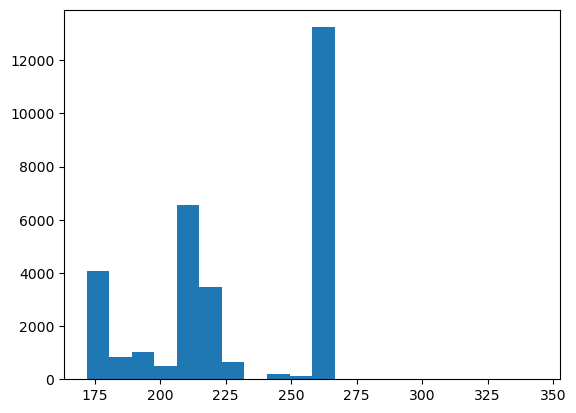

In [23]:
print(stations_count_agg['id_station'].unique())
plt.hist(stations_count_agg['id_station'], bins = 20)

In [26]:
max(stations_count_agg['id_station'])

344

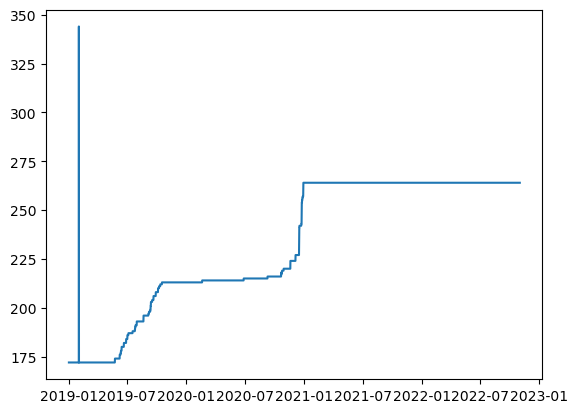

In [24]:
plt.plot(stations_count_agg['time'], stations_count_agg['id_station'])